# Dask DataFrames

<img src="images/dask-dataframe.svg" 
     align="right"
     width="20%"
     alt="Dask dataframes are blocked Pandas dataframes">
     
Dask Dataframes coordinate many Pandas dataframes, partitioned along an index.  They support a large subset of the Pandas API.

## Start Dask Client for Dashboard

Starting the Dask Client is optional.  It will provide a dashboard which 
is useful to gain insight on the computation.  

The link to the dashboard will become visible when you create the client below.  We recommend having it open on one side of your screen while using your notebook on the other side.  This can take some effort to arrange your windows, but seeing them both at the same is very useful when learning.

In [1]:
from dask.distributed import Client, progress
client = Client(n_workers=2, threads_per_worker=2, memory_limit='2GB')
client

Client Scheduler: tcp://127.0.0.1:42611 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 2 Cores: 4 Memory: 4.00 GB


## Create Random Dataframe

We create a random timeseries of data with the following attributes:

1.  It stores a record for every second of the month January 2000
2.  It splits that month by day, keeping every day as a separate Pandas dataframe
3.  Along with a datetime index it has columns for names, ids, and numeric values

This is a small dataset of about 240 MB. Increase the number of days or reduce the frequency to practice with a larger dataset.

In [3]:
import dask
import dask.dataframe as dd
ddf = dask.datasets.timeseries()

/home/izel/miniconda3/envs/dask-examples/lib/python3.7/site-packages/dask/dataframe/io/demo.py:91: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=partition_freq))
/home/izel/miniconda3/envs/dask-examples/lib/python3.7/site-packages/dask/dataframe/io/demo.py:45: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  index = pd.DatetimeIndex(start=start, end=end, freq=freq, name='timestamp')


Unlike Pandas, Dask DataFrames are lazy and so no data is printed here.

In [4]:
ddf

,id,name,x,y
npartitions=30,,,,
2000-01-01,int64,object,float64,float64
2000-01-02,...,...,...,...
...,...,...,...,...
2000-01-30,...,...,...,...
2000-01-31,...,...,...,...


But the column names and dtypes are known.

In [5]:
ddf.dtypes

id        int64
name     object
x       float64
y       float64
dtype: object

In [13]:
def human_readable_size(size,precision=2):
    suffixes=['B','KB','MB','GB','TB']
    suffixIndex = 0
    while size > 1024 and suffixIndex < 4:
        suffixIndex += 1 
        size = size/1024.0
    return "%.*f%s"%(precision,size,suffixes[suffixIndex])

### Let's see how much memory we need to store all the data

In [14]:
human_readable_size(ddf.memory_usage(deep=True).sum().compute())

'233.22MB'

### Let's see how much time we need to store all the data

In [16]:
import time
start_time = time.time()
df = ddf.compute()
print("--- %.2f seconds ---" % (time.time() - start_time))

--- 6.47 seconds ---


### Check whether we really stored the data

In [18]:
import sys
human_readable_size(sys.getsizeof(df))

'233.22MB'

In [21]:
len(df)

2592000

## Measure Performance

In [105]:
CHUNK_SIZE = 100000

### Measure sum performance

In [106]:
def measure_sum_speed():
    len_df = len(df)
    dask_speed = []
    pandas_speed = []
    for count in range(CHUNK_SIZE, len_df, CHUNK_SIZE):
        ddf_chunk = ddf.head(count, compute=False)
        df_chunk = df.head(count)
        start_time = time.time()
        ddf_chunk.x.sum().compute()
        dask_speed.append((time.time() - start_time))
        start_time = time.time()
        df_chunk.x.sum()
        pandas_speed.append((time.time() - start_time))
    return dask_speed, pandas_speed

In [107]:
dask_speed, pandas_speed = measure_sum_speed()

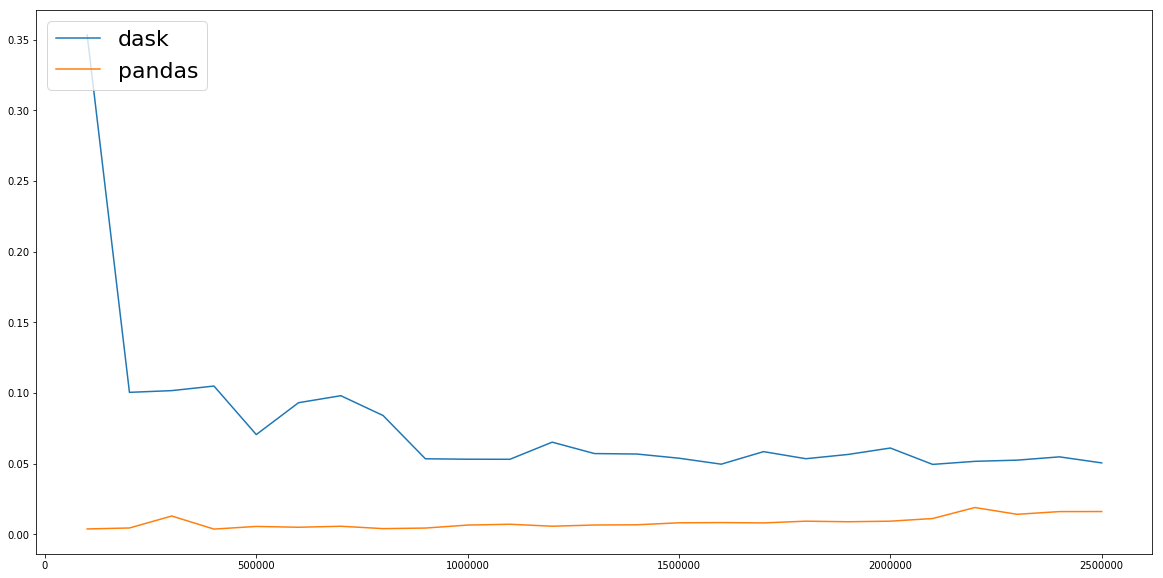

In [108]:
import matplotlib.pyplot as plt
import numpy as np

x = range(CHUNK_SIZE, len(df), CHUNK_SIZE)
f, ax = plt.subplots(1,figsize=(20,10))

ax.plot(x, dask_speed)
ax.plot(x, pandas_speed)
ax.legend(['dask', 'pandas'], loc='upper left', fontsize=22)
f.show()

### Measure train performance

In [109]:
from sklearn.linear_model import LinearRegression

def train(partition):
    est = LinearRegression()
    est.fit(partition[['x']].values, partition.y.values)

In [122]:
import pandas as pd
def measure_train_speed():
    len_df = len(df)
    dask_speed = []
    pandas_speed = []
    for count in range(100000, len_df, 100000):
        ddf_chunk = ddf.head(count, compute=False)
        df_chunk = df.head(count)
        start_time = time.time()
        ddf_chunk.groupby('name').apply(train, meta=object).compute()
        dask_speed.append((time.time() - start_time))
        start_time = time.time()
        df_chunk.groupby('name').apply(train)
        pandas_speed.append((time.time() - start_time))
    return dask_speed, pandas_speed

In [124]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
dask_speed, pandas_speed = measure_train_speed()

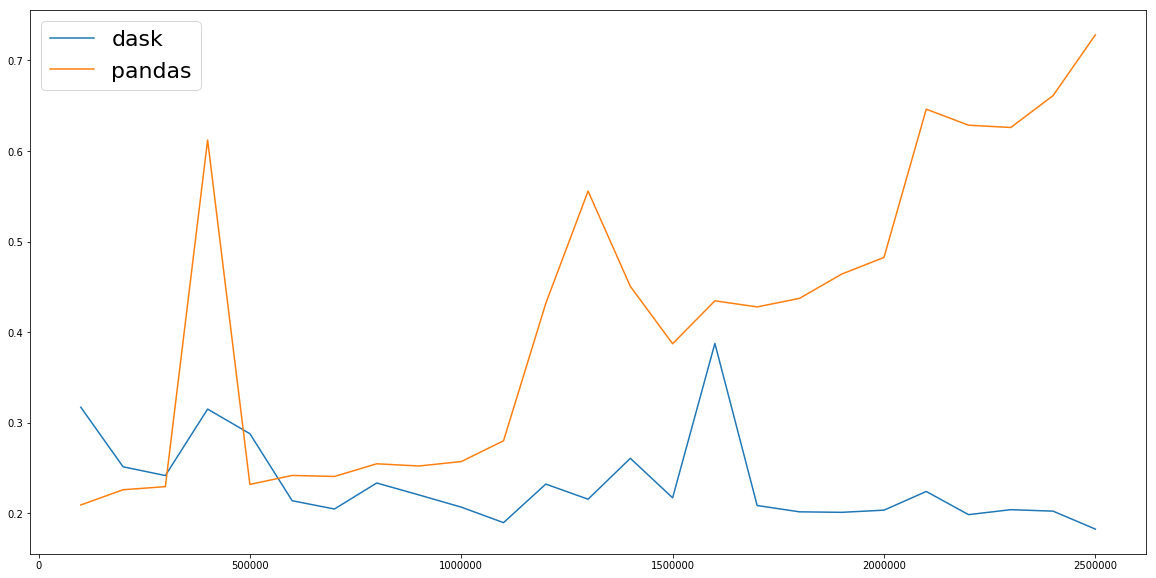

In [123]:
import matplotlib.pyplot as plt
import numpy as np

x = range(CHUNK_SIZE, len(df), CHUNK_SIZE)
f, ax = plt.subplots(1,figsize=(20,10))

ax.plot(x, dask_speed)
ax.plot(x, pandas_speed)
ax.legend(['dask', 'pandas'], loc='upper left', fontsize=22)
f.show()